In [1]:
import sys
import os

current_directory = os.getcwd()        
parent_directory = os.path.dirname(current_directory)
sys.path.append(parent_directory)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from math import sqrt
from tensorflow import keras
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from spektral.layers import GCNConv

from postprocess.threshold import flood_threshold, drought_threshold
from preprocess.BaselinePrerocess import baseline_process, baseline_process_for_gate_predictor
from preprocess.GraphTransformerPrerocess import graph_water_transformer_cov_process_for_gate_predictor
from preprocess.graph import graph_topology_5

import pygad
import time

2023-08-11 02:23:02.188723: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-11 02:23:03.534577: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

### Preprocess

In [4]:
# ====== preprocessing parameters ======
n_hours = 72
K = 24 
masked_value = 1e-10
split_1 = 0.8
split_2 = 0.9
sigma2 = 0.1
epsilon = 0.5

In [5]:
train_cov, val_cov, test_cov, \
train_tws_reshape, val_tws_reshape, test_tws_reshape, \
train_gate_pump_y, val_gate_pump_y, test_gate_pump_y, \
train_ws_y, val_ws_y, test_ws_y, \
scaler, ws_scaler, gate_scalar = graph_water_transformer_cov_process_for_gate_predictor(n_hours, K, masked_value, split_1, split_2)

Index(['WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A', 'TWS_S25A',
       'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B', 'TWS_S25B',
       'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2', 'HWS_S26',
       'TWS_S26', 'PUMP_S26', 'MEAN_RAIN'],
      dtype='object')
train_tws/val_tws/test_tws: (77069, 5, 72) (9634, 5, 72) (19268, 5, 72) 
 train_cov/val_cov/test_cov: (77069, 96, 12) (9634, 96, 12) (19268, 96, 12) 
 train_ws_y/val_ws_y/test_ws_y: (77069, 96) (9634, 96) (19268, 96) 
  train_gate_pump_y/val_gate_pump_y/test_gate_pump_y: (77069, 24, 7) (9634, 24, 7) (19268, 24, 7)


In [6]:
train_adj_mat, val_adj_mat, test_adj_mat = graph_topology_5(n_hours, K, sigma2, epsilon, len(train_ws_y), len(val_ws_y), len(test_ws_y))

node_indices: [0 0 0 0 1 1 2 2 3 3 4 4] 
neighbor_indices: [1 2 3 4 0 2 0 1 0 4 0 3]
number of nodes: 5, number of edges: 12


### Select event

In [11]:
start_idx = 7617
end_idx = 7657
duration = end_idx - start_idx

In [12]:
ws1 = test_ws_y[start_idx:end_idx, :]
ws1 = ws_scaler.inverse_transform(ws1)
ws1.shape

(40, 96)

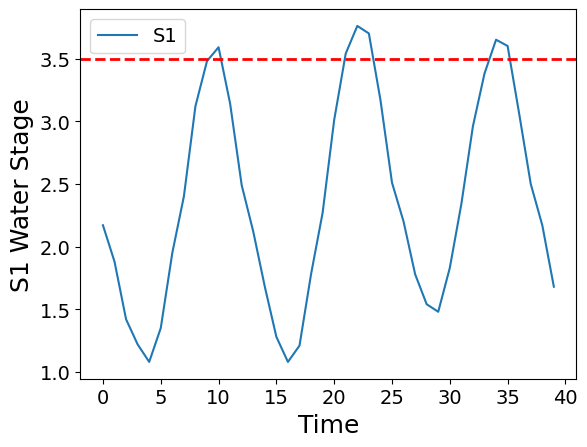

In [13]:
plt.plot(ws1[:, 0], label='S1')
plt.axhline(y = 3.5, color='r', linestyle='dashed', linewidth=2)
plt.xlabel('Time', fontsize=18)
plt.ylabel('S1 Water Stage', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.show()

### Get optimizable and not optimizable variables

In [14]:
# X = test_X_mask[start_idx:end_idx, :, :]
# X_1d = np.reshape(X, -1)

# print(X.shape)
# print(X_1d.shape)

In [15]:
# optimizable
gate_state = test_cov[start_idx:end_idx, :, 2:9]
gate_state_1d = np.reshape(gate_state, -1)

print(gate_state.shape)
print(gate_state_1d.shape)

(40, 96, 7)
(26880,)


In [16]:
# not optimizable
not_gate1 = test_cov[start_idx:end_idx, :, 0:2]

print(not_gate1.shape)

(40, 96, 2)


In [17]:
# not optimizable
not_gate2 = test_cov[start_idx:end_idx, :, 9:]

print(not_gate2.shape)

(40, 96, 3)


### GA

In [18]:
saved_model = load_model('../saved_models/WaLeF_gtn_p.h5', custom_objects={'GCNConv': GCNConv})
# load_model('cnn.h5', compile=False)

2023-08-11 02:25:57.741791: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10402 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:08:00.0, compute capability: 6.1


In [46]:
def fitness_func(ga_instance, solution, solution_idx):
    # ================ get input numpy of gate ================
    solution = np.reshape(solution, (duration, 96, 7))
    input_np = np.zeros(((duration, 96, 12)))
    input_np[:, :, 0:2] = not_gate1
    input_np[:, :, 2:9] = solution
    input_np[:, :, 9:] = not_gate2
    
    # ================ predict ws ================
    yhat = saved_model.predict([input_np, test_tws_reshape[start_idx:end_idx], test_adj_mat[start_idx:end_idx]])
    #yhat = saved_model.predict(input_np, verbose=0)
    
    
    # ================ ws penalty ================
    y_max = 0.62
    y_min = 0.2
    
    ws_penalty_sum = 0
    for i in range (duration):
        for j in range (96):
            if (yhat[i, j] > y_max):
                penalty_ws = np.abs(yhat[i, j] - y_max) + 20*np.abs(yhat[i, j] - y_max)**2
            elif (yhat[i, j] < y_min):
                penalty_ws = np.abs(y_min - yhat[i, j])
                
            else:
                penalty_ws = 0
            
            ws_penalty_sum += penalty_ws
    
    if ws_penalty_sum == 0:
        fitness = 9999999999999
    else:
        fitness = 1.0 / ws_penalty_sum
    return fitness

In [47]:
fitness_function = fitness_func

num_generations = 500
num_parents_mating = 16

sol_per_pop = 64
num_genes = len(gate_state_1d)

init_range_low = 0
init_range_high = 1

parent_selection_type = "sss"
keep_parents = 1

crossover_type = "single_point"

mutation_type = "random"
mutation_percent_genes = 5

In [48]:
ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       init_range_low=init_range_low,
                       init_range_high=init_range_high,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                       gene_space = {'low': 0, 'high': 1}
                      )

In [49]:
start_time = time.perf_counter()
ga_instance.run()
cpu_time = time.perf_counter() - start_time
print(f"CPU time: {cpu_time} seconds")

2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step
CPU time: 4229.107091174927 seconds


In [ ]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

2/2 [==============================] - 0s 4ms/step


### Post-processing

In [ ]:
best_gate = np.reshape(solution, (duration, 96, 7))

best_input = np.zeros(((duration, 96, 12)))
best_input[:, :, 0:2] = not_gate1
best_input[:, :, 2:9] = best_gate
best_input[:, :, 9:] = not_gate2

best_perf = saved_model.predict([best_input, test_tws_reshape[start_idx:end_idx], test_adj_mat[start_idx:end_idx]])
best_perf = ws_scaler.inverse_transform(best_perf)

In [ ]:
print(best_gate.shape, best_perf.shape)

In [ ]:
best_gate.reshape((duration, 96*7)).shape

In [ ]:
count = 0

for i in range (duration):
    for j in range (96):
        if best_perf[i, j] > 3.5:
            count += 1

print(count)

In [ ]:
plt.plot(best_perf[:, 0], label='S1')
plt.axhline(y = 3.5, color='r', linestyle='dashed', linewidth=2)
plt.xlabel('Time', fontsize=18)
plt.ylabel('S1 Water Stage', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.show()

In [ ]:
Optimal_gate = pd.DataFrame(best_gate.reshape(duration, -1) )
Optimal_gate.to_csv("GA_results/best_gate_event_Sep3.csv", index=False)
Optimal_gate

In [ ]:
Optimal_gate = pd.read_csv('GA_results/best_gate_event_Sep3.csv')
Optimal_gate

In [ ]:
Optimal_case = pd.DataFrame(best_perf)
Optimal_case.to_csv("GA_results/best_gate_event_Sep3.csv", index=False)
Optimal_case

In [ ]:
Optimal_case = pd.read_csv("GA_results/best_gate_event_Sep3.csv")
Optimal_case

In [ ]:
from postprocess.threshold import flood_threshold, drought_threshold, flood_threshold_t1, drought_threshold_t1

In [ ]:
upper_threshold = 3.5
lower_threshold = 0
t = 0

Optimal_case_reshape = Optimal_case.to_numpy().reshape((-1, 24, 4))

flood_threshold_t1(Optimal_case_reshape, t, upper_threshold)
drought_threshold_t1(Optimal_case_reshape, t, lower_threshold)
